# Second Hands Prices

This is a review of the AutoTrader data we have regarding second hand vehicle sales. The plots below aim to assist in our understanding of monthly trends in new registrations and the prices of vehicles over time.

Created for New AutoMotive by Corrin Reilly.

Notes:
- Vehicles from the 'Other' category are generally ignored.

## Imports

In [64]:
# Packages
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from mplcursors import cursor
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pmdarima.arima import auto_arima
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modules
from modules.connector import MyBigQuery

## Initialise Connections

In [2]:
bq = MyBigQuery(
    credentials_file='./credentials/New AutoMotive Index-487e031dc242.json'
)

## Gather Data

In [3]:
df_sh = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )

    SELECT
        FORMAT_DATE('%Y-%m', DATE(dos)) AS month,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        MIN(price) as min_price,
        MAX(price) as max_price,
        AVG(price) as avg_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        COUNT(t.fuelType) AS registrations
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        month, ft
    ORDER BY
        month, ft ASC;
    """
)
df_sh.set_index('month', inplace=True)
df_sh.head()

,ft,min_price,max_price,avg_price,median_price,registrations
month,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15975.0,234488
2022-12,Electric,5995.0,179999.0,41034.287954,34910.0,12693
2022-12,Hybrid,2395.0,179995.0,32819.671634,28245.0,48446
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133
2022-12,Petrol,380.0,1000000.0,20107.689402,16000.0,272185


## Define Constants

In [4]:
# Define fuel type colours.
colors = {
    'Hybrid': 'blue',
    'Diesel': 'black',
    'Petrol': 'grey',
    'Electric': 'green'
}

## Prepare Data for Plotting

In [5]:
# Copy data to new DataFrame.
df_sh_prop = df_sh.copy()

totals = {}

# Calculate the total number of registrations for each month.
for date in df_sh_prop.index.unique():
    df_date = df_sh_prop[df_sh_prop.index == date].copy()
    total = df_date.registrations.sum()
    totals[date] = total

In [6]:
# Update DataFrame to have a column for the total registrations for that month.
for index, row in df_sh_prop.iterrows():
    if index in totals:
        df_sh_prop.loc[index, 'sum'] = totals[index]

df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum
month,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15975.0,234488,567945.0
2022-12,Electric,5995.0,179999.0,41034.287954,34910.0,12693,567945.0
2022-12,Hybrid,2395.0,179995.0,32819.671634,28245.0,48446,567945.0
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0
2022-12,Petrol,380.0,1000000.0,20107.689402,16000.0,272185,567945.0


In [7]:
# Create a column that shows the proportion (%) of the months registrations that fuel type accounts for.
df_sh_prop['proportion'] = df_sh_prop.apply(lambda x: (100 * x['registrations']) / x['sum'] if x['sum'] != 0 else 0, axis=1)
df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum,proportion
month,,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15975.0,234488,567945.0,41.287096
2022-12,Electric,5995.0,179999.0,41034.287954,34910.0,12693,567945.0,2.234900
2022-12,Hybrid,2395.0,179995.0,32819.671634,28245.0,48446,567945.0,8.530051
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0,0.023418
2022-12,Petrol,380.0,1000000.0,20107.689402,16000.0,272185,567945.0,47.924535


## Create Plots

### No. of New Registrations by Fuel Type and Month

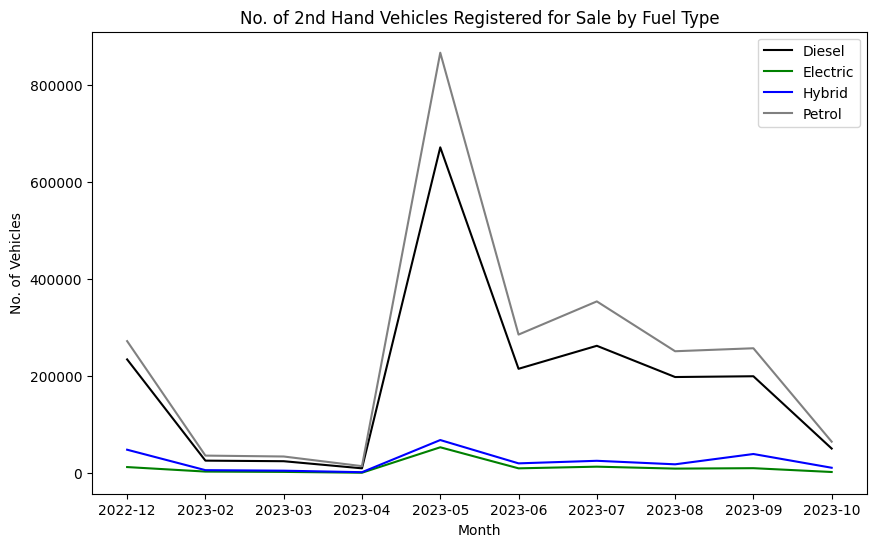

In [8]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.registrations, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('No. of Vehicles')
ax.set_title('No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Monthly Difference in New Registrations.

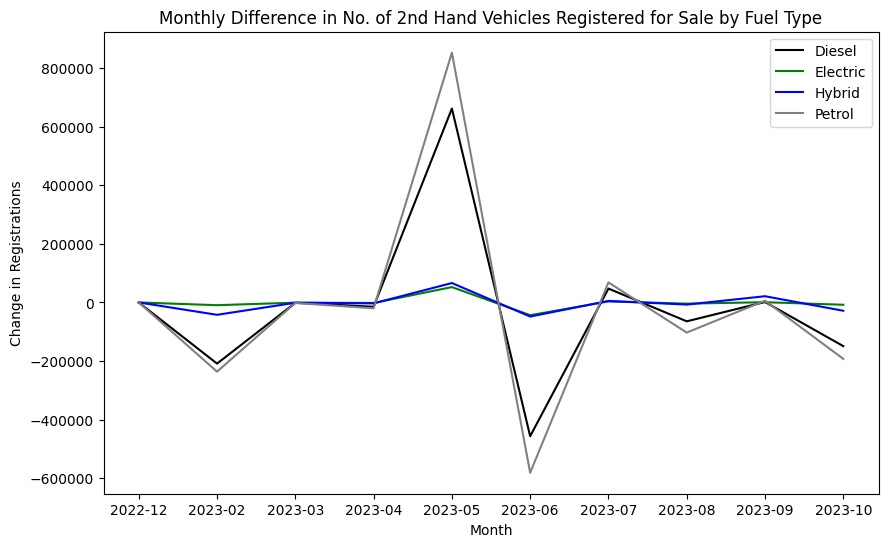

In [9]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        df_plot['diff'] = df_plot['registrations'].diff()
        df_plot['diff'].fillna(0, inplace=True)
        ax.plot(df_plot.index, df_plot['diff'], label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Change in Registrations')
ax.set_title('Monthly Difference in No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Proportion of Each Fuel Type as New Registrations

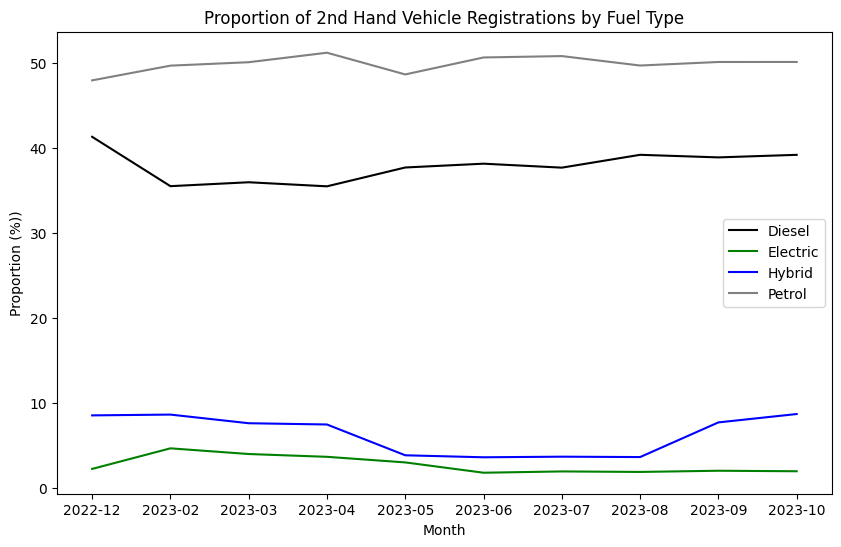

In [10]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.proportion, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Proportion (%))')
ax.set_title('Proportion of 2nd Hand Vehicle Registrations by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Avg. Price of New Registrations by Fuel Type

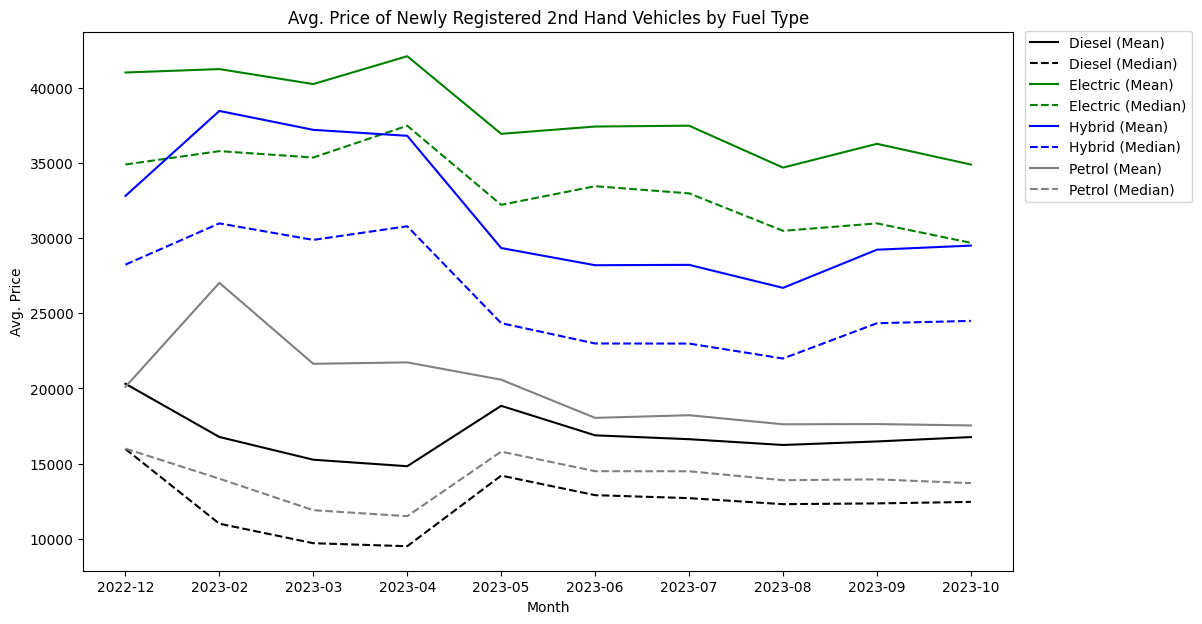

In [11]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.avg_price, label=ft + ' (Mean)', color=colors[ft])
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linestyle='dashed')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Avg. Price')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.2, 1.015), loc='upper right')

plt.show()

### Plot of Median and Min. Prices of Fuel Types

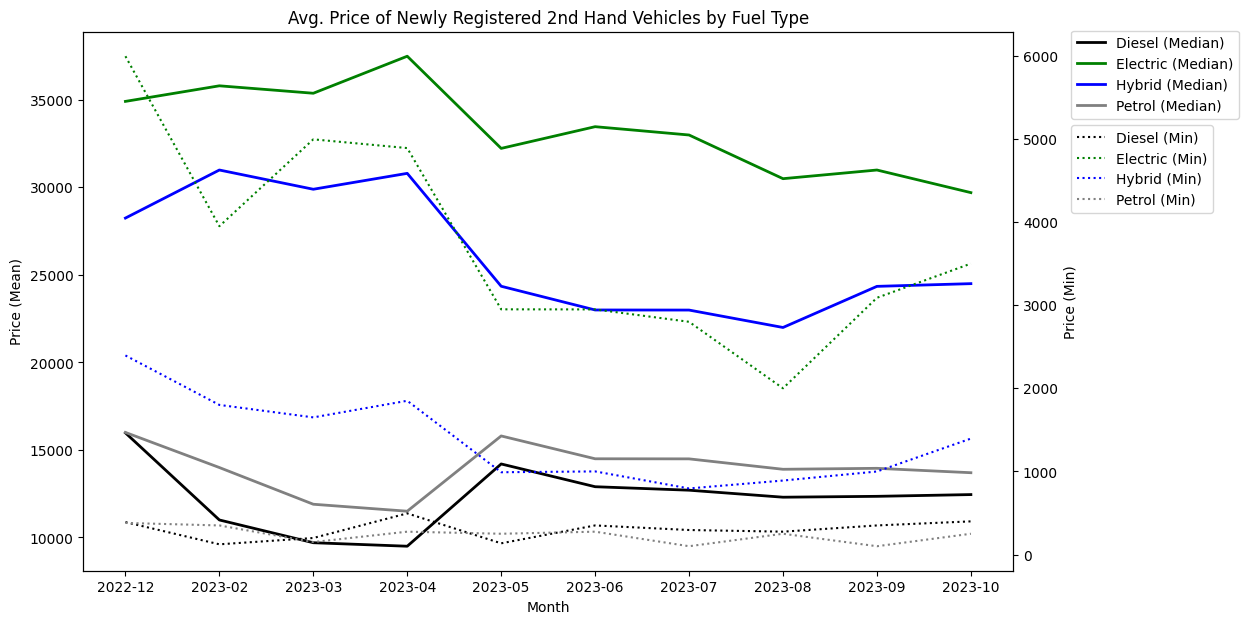

In [12]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Min)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.min_price, label=ft + ' (Min)', color=colors[ft], linestyle=':')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.25, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

plt.show()

### Plot of Median and Max. Prices of Fuel Types

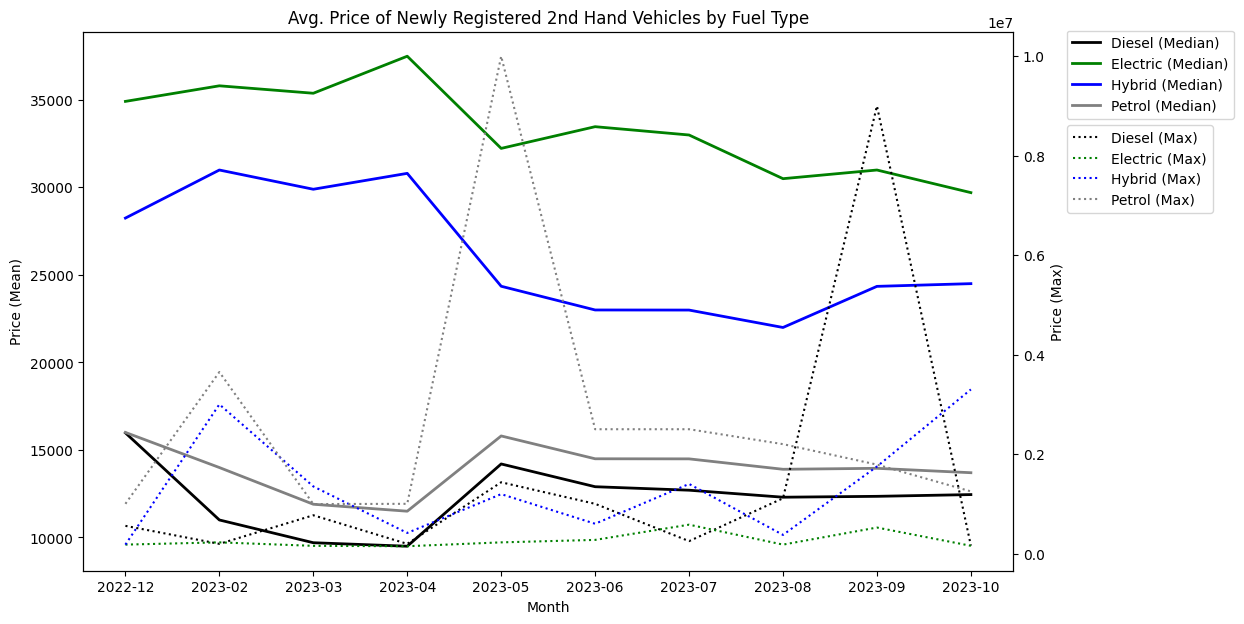

In [13]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Max)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.max_price, label=ft + ' (Max)', color=colors[ft], linestyle=':')

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend.
ax.legend(bbox_to_anchor=(1.245, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

# Show the plot.
plt.show()

## Projections: Linear Regression

In [14]:
df_lr = df_sh_prop.copy()
df_lr.index = pd.to_datetime(df_lr.index, format="%Y-%m")
df_lr

,ft,min_price,max_price,avg_price,median_price,registrations,sum,proportion
month,,,,,,,,
2022-12-01,Diesel,390.0,556950.0,20315.275673,15975.0,234488,567945.0,41.287096
2022-12-01,Electric,5995.0,179999.0,41034.287954,34910.0,12693,567945.0,2.234900
2022-12-01,Hybrid,2395.0,179995.0,32819.671634,28245.0,48446,567945.0,8.530051
2022-12-01,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0,0.023418
2022-12-01,Petrol,380.0,1000000.0,20107.689402,16000.0,272185,567945.0,47.924535
2023-02-01,Diesel,123.0,195000.0,16771.422053,11000.0,25947,73123.0,35.484047
2023-02-01,Electric,3950.0,225000.0,41261.425676,35800.0,3404,73123.0,4.655170
2023-02-01,Hybrid,1800.0,2999830.0,38476.291468,30990.0,6306,73123.0,8.623826
2023-02-01,Other,189.0,1500000.0,16307.942907,609.0,1156,73123.0,1.580898


In [15]:
df_lr_petrol = df_lr.query('ft == "Petrol"').copy()

X = sm.add_constant(df_lr_petrol.index.to_julian_date(), has_constant='add')

petrol_model = sm.OLS(df_lr_petrol['median_price'], X).fit()

petrol_model.summary()

/Users/corrinreilly/anaconda3/envs/nam-ad-hoc/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           median_price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.116
Method:                 Least Squares   F-statistic:                   0.06337
Date:                Mon, 02 Oct 2023   Prob (F-statistic):              0.808
Time:                        12:03:03   Log-Likelihood:                -86.300
No. Observations:                  10   AIC:                             176.6
Df Residuals:                       8   BIC:                             177.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.223e+06   1.27e+07      0.253      0.807   -2.62e+07    3.26e+07
x1            -1.3046      5.182     -0.252      0.808     -13.255      10.646
==============================================================================
Omnibus:                        1.096   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.634
Skew:                          -0.569   Prob(JB):                        0.728
Kurtosis:                       2.521   Cond. No.                     6.55e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
df_lr = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )

    SELECT
        DATE(dos) AS date,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        MIN(price) as min_price,
        MAX(price) as max_price,
        AVG(price) as avg_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        COUNT(t.fuelType) AS registrations
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        date, ft
    ORDER BY
        date, ft ASC;
    """
)
df_lr.head(10)

,date,ft,min_price,max_price,avg_price,median_price,registrations
0,2022-12-15,Diesel,390.0,556950.0,20315.275673,15792.0,234488
1,2022-12-15,Electric,5995.0,179999.0,41034.287954,34655.0,12693
2,2022-12-15,Hybrid,2395.0,179995.0,32819.671634,28178.0,48446
3,2022-12-15,Other,1495.0,749995.0,23971.481203,11995.0,133
4,2022-12-15,Petrol,380.0,1000000.0,20107.689402,16200.0,272185
5,2023-02-27,Diesel,123.0,195000.0,16771.422053,11199.0,25947
6,2023-02-27,Electric,3950.0,225000.0,41261.425676,36000.0,3404
7,2023-02-27,Hybrid,1800.0,2999830.0,38476.291468,30925.0,6306
8,2023-02-27,Other,189.0,1500000.0,16307.942907,597.0,1156
9,2023-02-27,Petrol,350.0,3650000.0,27034.205591,14000.0,36310


In [50]:
df_lr['date'] = pd.to_datetime(df_lr['date'])
df_lr = df_lr.sort_values(by='date')

In [51]:
ft_categories = df_lr['ft'].unique()

In [56]:
def time_series_analysis(df, ft_category):
    # Filter the DataFrame for the specific 'ft' category
    df_ft = df[df['ft'] == ft_category]
    
    # Extract the date and median_price columns
    dates = df_ft['date']
    median_prices = df_ft['median_price']
    
    # Create a DataFrame to store predictions
    predictions_df = pd.DataFrame(columns=['date', 'median_price'])
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Iterate over weeks for prediction
    latest_date = df['date'].max()
    for i in range(1, 105):
        # Calculate the prediction date
        prediction_date = latest_date + timedelta(weeks=i)
        
        # Fit the model on available data
        X = (dates - latest_date).dt.days.values.reshape(-1, 1)
        y = median_prices.values
        model.fit(X, y)
        
        # Make a prediction for the future date
        prediction_days = (prediction_date - latest_date).days
        predicted_price = model.predict([[prediction_days]])[0]
        
        # Append the prediction to the DataFrame
        predictions_df = predictions_df.append({'date': prediction_date, 'median_price': predicted_price}, ignore_index=True)
    
    return predictions_df

In [57]:
predicted_dfs = {}
for ft_category in ft_categories:
    predictions_df = time_series_analysis(df_lr, ft_category)
    predicted_dfs[ft_category] = predictions_df
predicted_dfs

/var/folders/zr/78p1jh255yv8qntrmszjl_w80000gn/T/ipykernel_4545/1369635289.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'date': prediction_date, 'median_price': predicted_price}, ignore_index=True)
/var/folders/zr/78p1jh255yv8qntrmszjl_w80000gn/T/ipykernel_4545/1369635289.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'date': prediction_date, 'median_price': predicted_price}, ignore_index=True)
/var/folders/zr/78p1jh255yv8qntrmszjl_w80000gn/T/ipykernel_4545/1369635289.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'date': prediction_date, 'median_price': predicted_price}, ignore_index=T

{'Diesel':           date  median_price
 0   2023-10-09  12598.388384
 1   2023-10-16  12622.184071
 2   2023-10-23  12645.979758
 3   2023-10-30  12669.775445
 4   2023-11-06  12693.571132
 ..         ...           ...
 99  2025-09-01  14954.161400
 100 2025-09-08  14977.957087
 101 2025-09-15  15001.752774
 102 2025-09-22  15025.548461
 103 2025-09-29  15049.344148
 
 [104 rows x 2 columns],
 'Electric':           date  median_price
 0   2023-10-09  29987.950869
 1   2023-10-16  29809.278280
 2   2023-10-23  29630.605691
 3   2023-10-30  29451.933103
 4   2023-11-06  29273.260514
 ..         ...           ...
 99  2025-09-01  12299.364569
 100 2025-09-08  12120.691980
 101 2025-09-15  11942.019392
 102 2025-09-22  11763.346803
 103 2025-09-29  11584.674214
 
 [104 rows x 2 columns],
 'Hybrid':           date  median_price
 0   2023-10-09  21274.586654
 1   2023-10-16  21052.749888
 2   2023-10-23  20830.913122
 3   2023-10-30  20609.076356
 4   2023-11-06  20387.239590
 ..         ..

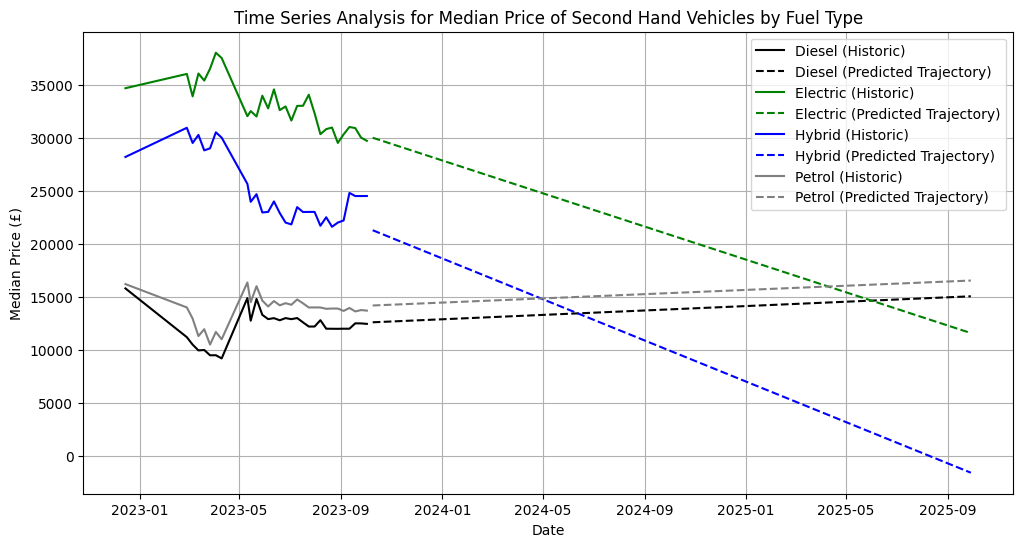

In [69]:
plt.figure(figsize=(12, 6))

# Iterate over each 'ft' category and plot the current data along with predictions
for ft_category in ft_categories:
    if ft_category != 'Other':
        # Filter the original DataFrame for the specific 'ft' category
        df_ft = df_lr[df_lr['ft'] == ft_category]
        
        # Get the corresponding predictions DataFrame
        predictions_df = predicted_dfs[ft_category]
        
        # Plot the current data
        plt.plot(df_ft['date'], df_ft['median_price'], label=f'{ft_category} (Historic)', linestyle='-', markersize=5, color=colors[ft_category])
        
        # Plot the predictions
        plt.plot(predictions_df['date'], predictions_df['median_price'], label=f'{ft_category} (Predicted Trajectory)', linestyle='--', color=colors[ft_category])

# Set labels and legend
plt.xlabel('Date')
plt.ylabel('Median Price (£)')
plt.title('Time Series Analysis for Median Price of Second Hand Vehicles by Fuel Type')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [67]:
# Create a figure
fig = go.Figure()

# Iterate over each 'ft' category and add the current data and predictions to the figure
for ft_category in ft_categories:
    if ft_category != 'Other':
        # Filter the original DataFrame for the specific 'ft' category
        df_ft = df_lr[df_lr['ft'] == ft_category]
        
        # Get the corresponding predictions DataFrame
        predictions_df = predicted_dfs[ft_category]
        
        # Add current data as a scatter plot
        fig.add_trace(
            go.Scatter(
                x=df_ft['date'],
                y=df_ft['median_price'],
                mode='lines',
                name=f'Current Data ({ft_category})',
                line=dict(color=colors[ft_category])
            )
        )
        
        # Add predictions as a line plot
        fig.add_trace(
            go.Scatter(
                x=predictions_df['date'],
                y=predictions_df['median_price'],
                mode='lines',
                name=f'Predictions ({ft_category})',
                line=dict(dash='dash', color=colors[ft_category])
            )
        )
    
# Update layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Median Price (£)',
    title='Time Series Analysis for Median Price of Second Hand Vehicles by Fuel Type',
    showlegend=True,
)

# Show the plot
fig.show()